In [1]:
%matplotlib inline
import os
import pandas as pd
import torch
import torchvision
from d2l import torch as d2l

In [2]:
d2l.DATA_HUB['banana-detection'] = (
    d2l.DATA_URL + 'banana-detection.zip',
    '5de26c8fce5ccdea9f91267273464dc968d20d72')

In [12]:
#@save
def read_data_bananas(is_train=True):
    """Read the banana detection dataset images and labels."""
    data_dir = d2l.download_extract('banana-detection')
    csv_fname = os.path.join(data_dir, 'bananas_train' if is_train
                             else 'bananas_val', 'label.csv')
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name')
    images, targets = [], []
    for img_name, target in csv_data.iterrows():
        images.append(torchvision.io.read_image(
            os.path.join(data_dir, 'bananas_train' if is_train else
                         'bananas_val', 'images', f'{img_name}')))
        # Here `target` contains (class, upper-left x, upper-left y,
        # lower-right x, lower-right y), where all the images have the same
        # banana class (index 0)
        targets.append(list(target))
    return images, torch.tensor(targets).unsqueeze(1) / 256

In [6]:
class BananaDataset(torch.utils.data.Dataset):
    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print('read ' + str(len(self.features)) +
              (f' training examples' if is_train else f' validation examples'))
        
    def __getitem__(self, idx):
        return (self.features[idx].float(), self.labels[idx])
    
    def __len__(self):
        return len(self.features)

In [8]:
def load_data_bananas(batch_size):
    train_iter = torch.utils.data.DataLoader(BananaDataset(is_train=True),
                                             batch_size, shuffle=True)
    val_iter = torch.utils.data.DataLoader(BananaDataset(is_train=False),
                                           batch_size)
    return train_iter, val_iter

In [13]:
batch_size, edge_size = 32, 256
train_iter, _ = load_data_bananas(batch_size)
batch = next(iter(train_iter))
batch[0].shape, batch[1].shape

read 1000 training examples
read 100 validation examples


(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 5]))

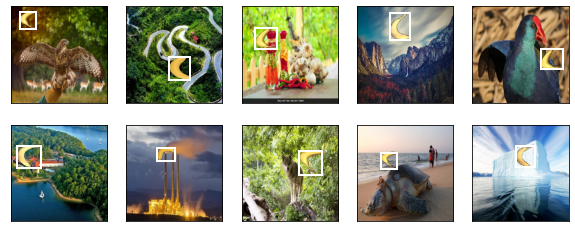

In [14]:
imgs = (batch[0][:10].permute(0, 2, 3, 1)) / 255
axes = d2l.show_images(imgs, 2, 5, scale=2)
for ax, label in zip(axes, batch[1][:10]):
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size],
                    colors=['w'])